In [23]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [24]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.encoderModel = nn.Sequential (
          nn.Linear(x_dim, h_dim1),
          nn.ReLU(),
          nn.Linear(h_dim1, h_dim2),
          nn.ReLU()
        )
        
        self.mu = nn.Linear(h_dim2, z_dim)
        self.log_var = nn.Linear(h_dim2, z_dim)

        # decoder part
        self.decoderModel = nn.Sequential (
          nn.Linear(z_dim, h_dim2),
          nn.ReLU(),
          nn.Linear(h_dim2, h_dim1),
          nn.ReLU(),
          nn.Linear(h_dim1, x_dim),
          nn.Sigmoid()
        )
        
    def encoder(self, x):
        h = self.encoderModel(x)
        return self.mu(h), self.log_var(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        return self.decoderModel(z)
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [25]:
vae

VAE(
  (encoderModel): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (log_var): Linear(in_features=256, out_features=2, bias=True)
  (decoderModel): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [26]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [27]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [28]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [29]:
for epoch in range(1, 6):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.412578
Train Epoch: 1 [10000/60000 (17%)]	Loss: 183.002344
Train Epoch: 1 [20000/60000 (33%)]	Loss: 174.398047
Train Epoch: 1 [30000/60000 (50%)]	Loss: 170.883730
Train Epoch: 1 [40000/60000 (67%)]	Loss: 158.981836
Train Epoch: 1 [50000/60000 (83%)]	Loss: 166.211680
====> Epoch: 1 Average loss: 177.8122
====> Test set loss: 162.3160
Train Epoch: 2 [0/60000 (0%)]	Loss: 157.022129
Train Epoch: 2 [10000/60000 (17%)]	Loss: 159.062773
Train Epoch: 2 [20000/60000 (33%)]	Loss: 143.775859
Train Epoch: 2 [30000/60000 (50%)]	Loss: 148.673379
Train Epoch: 2 [40000/60000 (67%)]	Loss: 158.301924
Train Epoch: 2 [50000/60000 (83%)]	Loss: 156.563643
====> Epoch: 2 Average loss: 158.1310
====> Test set loss: 155.6025
Train Epoch: 3 [0/60000 (0%)]	Loss: 168.788398
Train Epoch: 3 [10000/60000 (17%)]	Loss: 155.227979
Train Epoch: 3 [20000/60000 (33%)]	Loss: 159.109268
Train Epoch: 3 [30000/60000 (50%)]	Loss: 143.933701
Train Epoch: 3 [40000/60000 (67%)]	Loss: 147.77

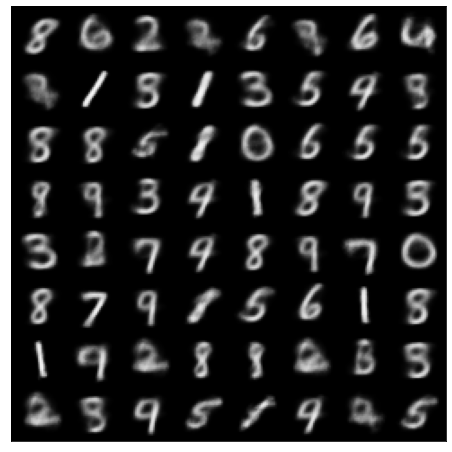

In [30]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()


with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    sample = sample.view(sample.size(0), 1, 28, 28).cpu()
    imshow(sample)
    